In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.preproc as pre
import utils.eval as ev

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [20]:
gmm_model_joint = torch.load('SavedModels/gmm_ACET_joint_lam=-2.pth').to(device)

base_model = torch.load('SavedModels/base_ACET.pth').to(device)
gmm = torch.load('SavedModels/MNIST_gmm.pth')
loglam = gmm_model_joint.loglam.data.item()
gmm_model_sep1 = models.RobustModel(base_model, gmm, loglam).to(device)
gmm_model_sep2 = models.RobustModel(base_model, gmm_model_joint.mm, loglam).to(device)

In [21]:
tt.test(base_model, device, dl.MNIST_test_loader)
tt.test(gmm_model_joint, device, dl.MNIST_test_loader)


Test set: Average loss: 0.0735, Accuracy: 9757/10000 (98%), Ave. Confidence: 97%


Test set: Average loss: 0.1985, Accuracy: 9772/10000 (98%), Ave. Confidence: 86%



(9772, 0.8580248844623566)

In [36]:
base_df1 = ev.evaluate_MNIST(gmm_model_sep1, device)
#base_df2 = ev.evaluate_MNIST(gmm_model_sep2, device)
gmm_df = ev.evaluate_MNIST(gmm_model_joint, device)

In [37]:
df_ACET = base_df1.merge(gmm_df, right_index=True, left_index=True, suffixes=("_sep", "_joint"))

In [38]:
df_ACET

,MMC_sep,AUROC_sep,FPR@95_sep,MMC_joint,AUROC_joint,FPR@95_joint
DataSet,,,,,,
MNIST,0.895477,-,-,0.858025,-,-
FMNIST,0.340394,0.992466,0,0.325128,0.992361,0
EMNIST,0.659893,0.893646,0.0135,0.606881,0.895526,0.0002
GrayCIFAR10,0.106542,0.999989,0,0.106387,0.999987,0
Noise,0.100017,1,0,0.100029,1,0
Adv. Noise,0.385642,0.969243,0.00980392,0.100031,1,0
Adv. Sample,0.878646,0.497103,0.239216,0.829783,0.492612,0.045098


In [13]:
base_df1

,MMC,AUROC,FPR@95
DataSet,,,
MNIST,0.959555,-,-
FMNIST,0.445582,0.985282,0.0034
EMNIST,0.762707,0.891386,0.2232
GrayCIFAR10,0.113843,0.99997,0
Noise,0.100018,1,0
Adv. Noise,0.253791,0.994296,0.00588235
Adv. Sample,0.919499,0.613868,0.709804


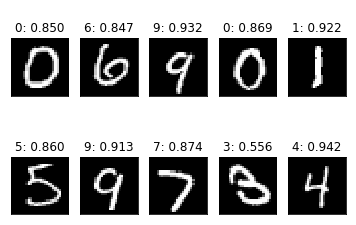

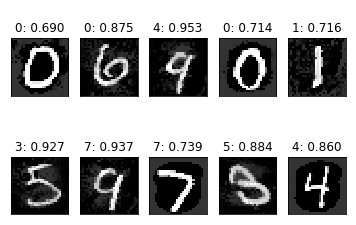

In [56]:
e = enumerate(dl.MNIST_test_loader)
e.__next__()
data, label = e.__next__()[1]
#data, label = enumerate(dl.Noise_loader).__next__()[1]


y_base = gmm_model_joint(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

data = adv.gen_adv_sample(gmm_model_joint, device, data, label, epsilon=0.3, steps=200)

y_base = gmm_model_joint(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

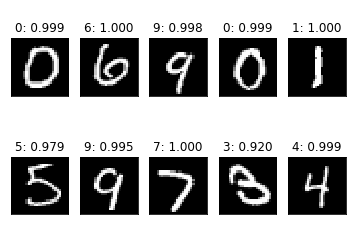

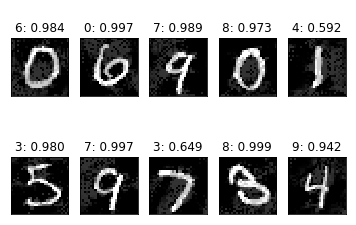

In [57]:
e = enumerate(dl.MNIST_test_loader)
e.__next__()
data, label = e.__next__()[1]

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

data = adv.gen_adv_sample(base_model, device, data, label, epsilon=0.3, steps=200)

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

In [50]:
gmm_model_joint.loglam-=3.

In [51]:
gmm_model_joint.loglam

Parameter containing:
tensor(-3., device='cuda:0')